In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import itertools
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 10 # number of realizations of training


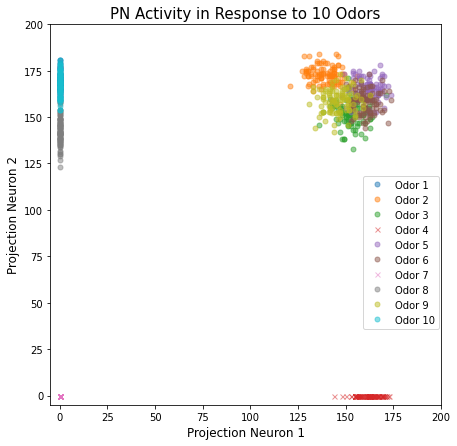

In [23]:
N = 10
num_pns = 40
num_inputs = 50000
spikes = 200

with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/input-means7.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means
# print(response)

bool_response = np.where(input_means > 0, 1, 0)
# print(bool_response)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs
    
# print("pn_inputs shape: {}".format(pn_inputs.shape))

# fire = np.ones((N, num_inputs//N))
# fire[2] = 0
# fire = fire.astype(int)
# print(fire)

# categories = ['x', 'o', 'o']
categories = ['o', 'o', 'o', 'x', 'o', 'o', 'x', 'o', 'o', 'o']
labels = []
for i in range(N):
    labels.append("Odor {}".format(i+1))

# plotting
plt.figure(figsize=(7,7))
for i in range(N):
    # 22, 23 - 10 odors
    # 9, 10 - 3 odors
    plt.plot(pn_inputs[i, 0:100, 22], pn_inputs[i, 0:100, 23], marker = categories[i], markersize=5, alpha = 0.5,
             label = labels[i], linestyle = '')
#     sns.scatterplot(x = pn_inputs[i, :, 9], y = pn_inputs[i, :, 10], s = 100, palette = 'Accent', style = categories[i])
plt.xlim(-5, 200)
plt.ylim(-5, 200)
plt.legend(loc=(0.8,0.2))
plt.title('PN Activity in Response to {} Odors'.format(N), fontsize=15)
plt.xlabel('Projection Neuron 1', fontsize=12)
plt.ylabel('Projection Neuron 2', fontsize=12)
plt.show()

### Number KC Removed in Pruning vs. Ablation (> 0.45 ER Difference)

In [47]:
num_mbons = 19
K = 23
T = 5000

# get the number kc from string arr
# a - num kcs removed
def get_num_kc(str, a):
    nums = np.zeros(a)
    for i in range(a):
        end = False
        s = str[i]
        j = 1
        num_str = ""
        while end == False:
            # end loop if space is reached
            if s[-j] == " ": 
                end = True
            else:
                num_str = s[-j] + num_str
            j += 1
        nums[i] = int(num_str)
    return nums

# mbon - index of mbon
def count_num_removed(kc_mbon, nums, mbon):
    count = 0
    nums = nums.astype(int)
    for i in range(len(nums)):
        if kc_mbon.iloc[nums[i], mbon] != 0:
            count += 1
    return count

# import data for pruning
# with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-pruning2/all-error-rates12.pkl', 'rb') as f:
#     error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_p = pickle.load(f) # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-pruning2/all-error-rates13.pkl', 'rb') as f:
    error_over_time_p = pickle.load(f) # dimensions: K, R, T, num_mbons
    
# import data for random ablation
# with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation2/all-error-rates14.pkl', 'rb') as f:
#     error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
# with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation2/kcs-removed14.pkl', 'rb') as f:
#     kcs_removed = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control_a = pickle.load(f) # dimensions: R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time_a = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/kcs-removed10.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)

# record x and y coordinates from every realization
x_total = np.zeros((R, num_mbons))
y_total = np.zeros((R, num_mbons))

# number of KCs supposedly to be removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist()

for r in range(R):

    # PRUNING
    # x-axis -> number of KCs removed 
    x_a = []

    for i in range(num_mbons):
        for j in range(K):
            x_a.append(numbers[j])
    # print(x_a)

    # y-axis - final error rate for realization r
    y_a = []
    for k in range(num_mbons):
        for i in range(K):
            y_a.append(error_over_time_p[i,r,-1,k] - error_control_p[r,-1,k])


    # ABLATION
    # gets number of presynaptic KCs for each MBON
    bool_synapses = np.where(kc_mbon > 0, 1, 0)
    conn = np.zeros(num_mbons)
    for j in range(num_mbons):
        conn[j] = bool_synapses[:,j].sum()
    conn = conn.astype(int)

    # x-axis -> number of KCs removed
    x_p = []

    # x-axis calculations - calculates the actual number of synapses removed
    for i in range(num_mbons):
        for j in range(K):
            n = numbers[j] # num kcs ablated
            l = kcs_removed[j][0] # list of kcs removed for realization 1
            l_num = get_num_kc(l, n) # converts list of names to numbers

            num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
            x_p.append(num_removed)    
    # print(x_p)

    # y-axis - final error rate for realization r
    y_p = []
    for m in range(num_mbons):
        for k in range(K):
            y_p.append(error_over_time_a[k, r, -1, m] - error_control_a[r, -1, m])
    # print(y_p)

    # SUMMARY
    # Get the x and y coordinates for summary plot
    x_p = np.asarray(x_p).reshape(num_mbons, K)
    y_p = np.asarray(y_p).reshape(num_mbons, K)

    x_a = np.asarray(x_a).reshape(num_mbons, K)
    y_a = np.asarray(y_a).reshape(num_mbons, K)

    x = np.zeros(num_mbons) # ablation
    y = np.zeros(num_mbons) # pruning

    for m in range(num_mbons):
        num_removed_x = 0
        # ablation
        found_a = False
        k_a = 0 # move through the columns
        while (not found_a) and (k_a < K):
            if y_a[m, k_a] > 0.45:
                x[m] = x_a[m, k_a]
                found_a = True
            k_a += 1

        # pruning
        found_p = False
        k_p = 0 # move through the columns
        while (not found_p) and (k_p < K):
            # ablation
            if y_p[m, k_p] > 0.45:
                y[m] = x_p[m, k_p]
                found_p = True
            k_p += 1 

    print("Realization {}".format(r+1))
    print("Ablation:", x)
    print("Pruning:", y)
    print()

    x_total[r] = x
    y_total[r] = y

Realization 1
Ablation: [ 25.  45.  40.  45.  55.  55.  60.  35.  30.  55.  50.  55.  35.  25.
  45.   0.  20.  35. 110.]
Pruning: [16. 32. 32. 45. 34. 33. 40. 23. 39. 58. 35. 51. 20. 21. 50.  0. 13. 27.
 90.]

Realization 2
Ablation: [25. 60. 45. 45. 55. 55. 60. 40. 60. 60. 45. 35. 35. 20. 40.  0. 15. 35.
 55.]
Pruning: [ 21.  37.  32.  39.  39.  37.  45.  23.  49.  58.  40.  51.  20.  21.
  50.   0.  11.  28. 110.]

Realization 3
Ablation: [ 25.  25.  45.  40.  55.  55.  45.  35.  25.  60.  45.  50.  40.  30.
  50.   0.  10.  35. 110.]
Pruning: [19. 37. 32. 30. 25. 30. 25. 19. 20. 58. 35. 51. 20. 17. 22.  0. 11. 28.
 75.]

Realization 4
Ablation: [ 55.  35.  45.  45.  50.  50.  60.  40.  30.  60.  55.  50.  35.  30.
  45.   0.  15.  30. 110.]
Pruning: [ 19.  61.  32.  21.  30.  30.  25.  19.  58.  58.  35.  51.  25.  19.
  50.   0.  11.  28. 110.]

Realization 5
Ablation: [ 20.  60.  40.  45.  55.  50.  50.  40.  15.  60.  55.  55.  30.  30.
  50.   0.  15.  35. 110.]
Pruning: [ 52. 

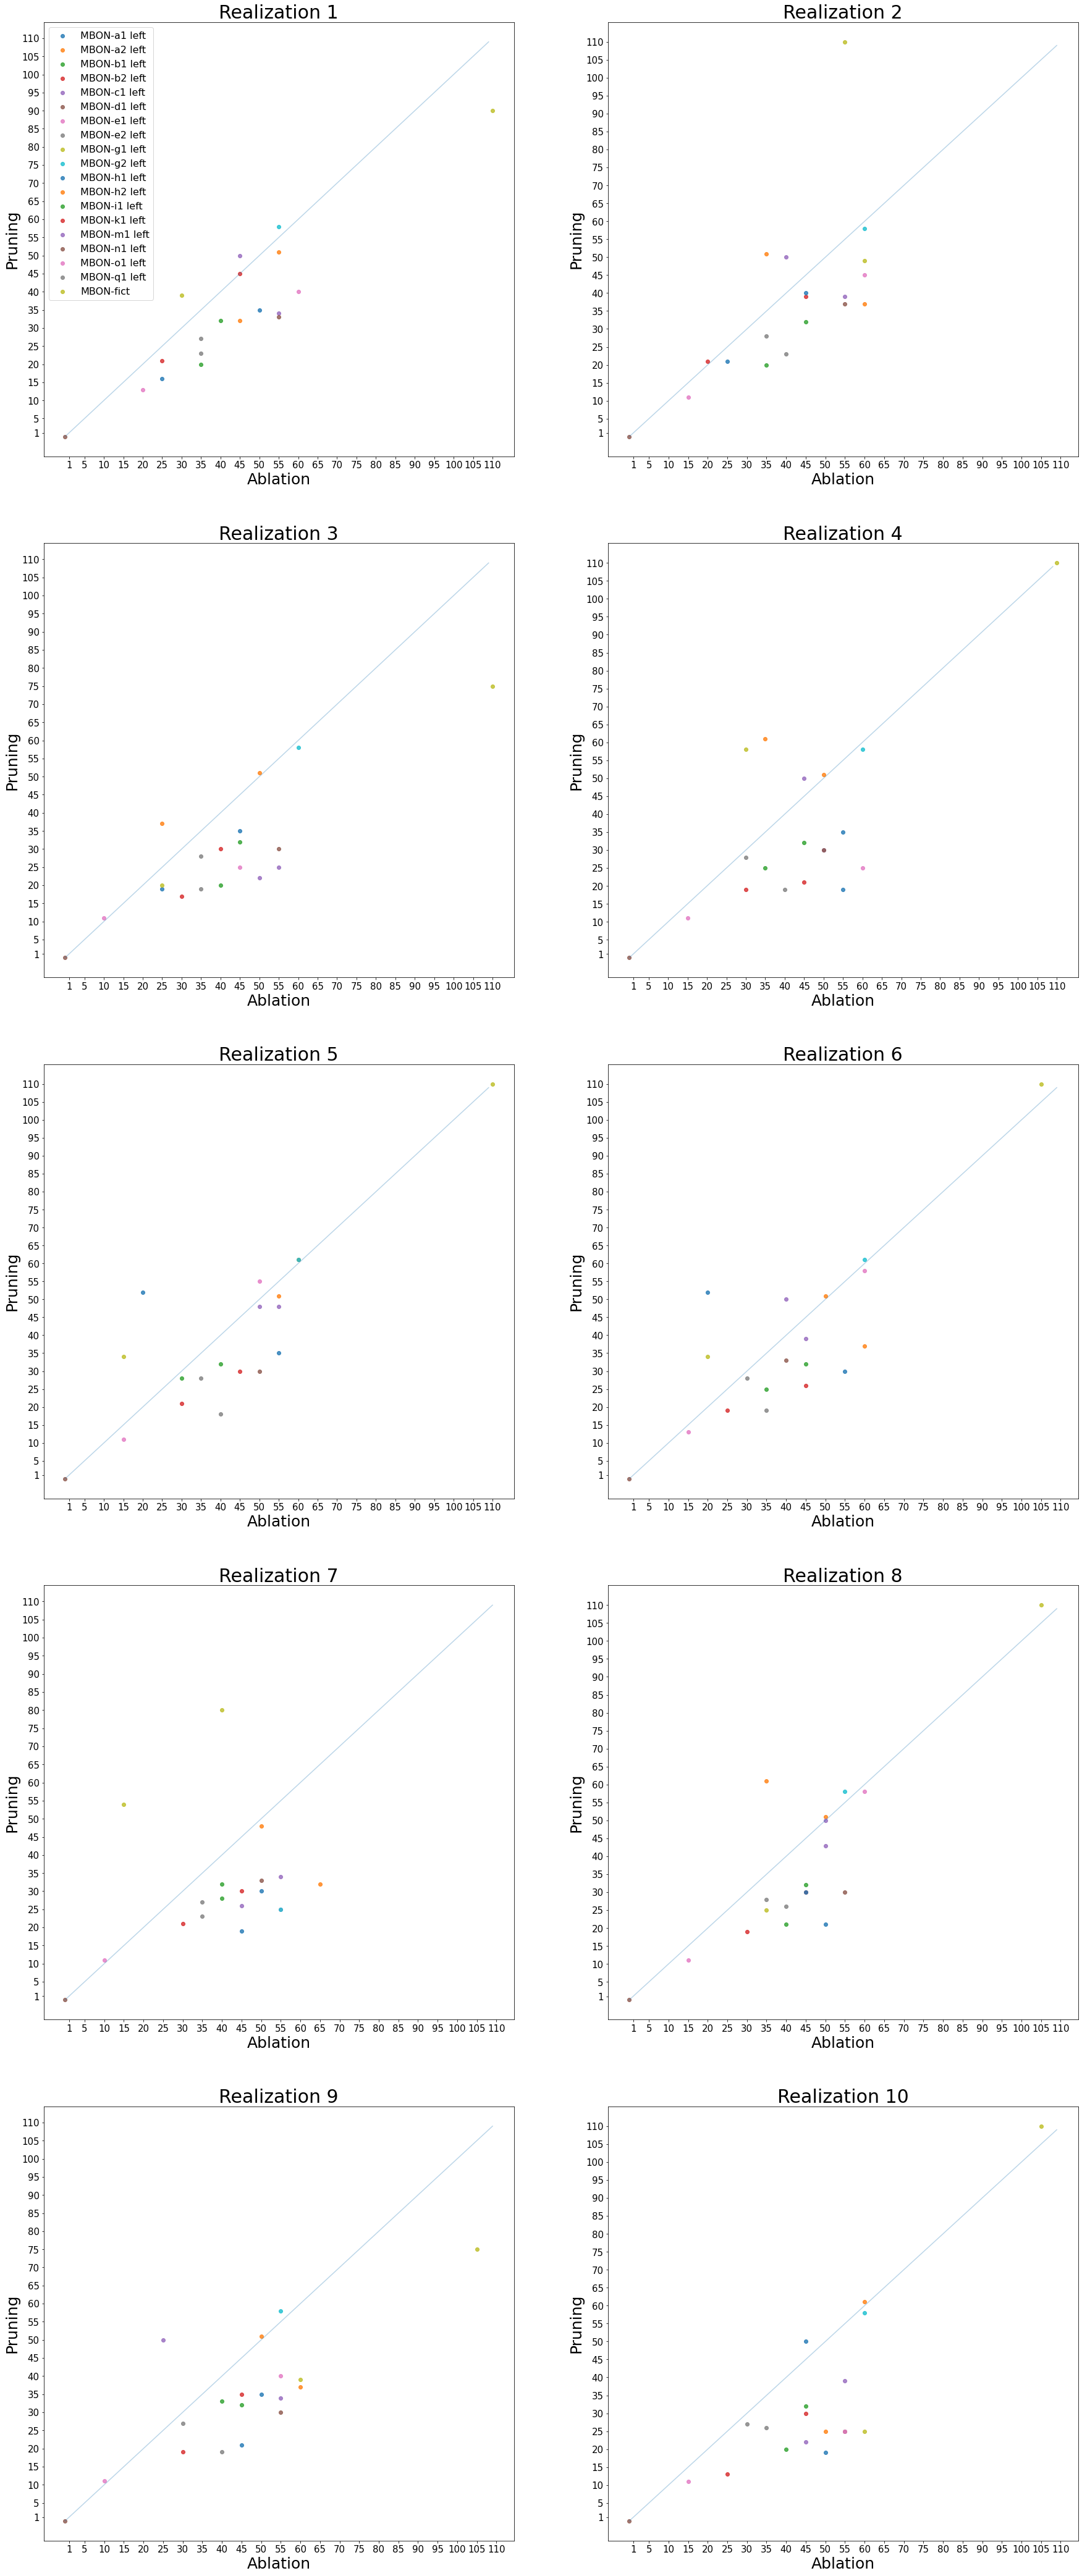

In [48]:
fig, ax = plt.subplots(5, 2, figsize=(30, 75))

names = kc_mbon.columns

r = 0
for i in range(5):
    for j in range(2):
        for m in range(num_mbons):
            ax[i, j].scatter(x_total[r, m], y_total[r, m], alpha=0.8, label=names[m])
        ax[i, j].plot(np.arange(110), np.arange(110), alpha=0.3)
        ax[i, j].set_xlabel("Ablation", fontsize=25)
        ax[i, j].set_ylabel("Pruning", fontsize=25)
        ax[i, j].set_xticks(numbers)
        ax[i, j].set_yticks(numbers)
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)
        ax[i, j].set_title(f"Realization {r+1}", fontsize=30)
        if r == 0:
            ax[i, j].legend(fontsize=16)

        r += 1
    
# plt.title("Random - # of KCs Removed in Pruning vs. Ablation (Threshold: > 0.45)", fontsize=20)
plt.show()

In [49]:
sum_slope = 0

for r in range(R):
    res = st.linregress(x_total[r], y_total[r])
    sum_slope += res.slope
    print(f"Realization {r+1}")
    print(res)
    print(f"R-squared: {res.rvalue**2}\n")
    
print(f"Average slope: {sum_slope / R}") 
# maybe take out the data for the fictional MBON? outlier is skewing results?

Realization 1
LinregressResult(slope=0.8045997610513741, intercept=-0.04062126642772057, rvalue=0.9094501200329791, pvalue=6.888976505909402e-08, stderr=0.08922255433059362, intercept_stderr=4.303372959217646)
R-squared: 0.8270995208280001

Realization 2
LinregressResult(slope=0.893624497991968, intercept=0.5002510040160573, rvalue=0.6636518222179991, pvalue=0.0019477507706505207, stderr=0.24429584122884884, intercept_stderr=10.878422042889985)
R-squared: 0.4404337411332707

Realization 3
LinregressResult(slope=0.6396050775740479, intercept=2.900423131170662, rvalue=0.84821299173616, pvalue=4.478951423435838e-06, stderr=0.09686699602676879, intercept_stderr=4.518942219678063)
R-squared: 0.7194652793500071

Realization 4
LinregressResult(slope=0.818018018018018, intercept=-0.2702702702702737, rvalue=0.7335403045679425, pvalue=0.0003513734608501935, stderr=0.18382186290464264, intercept_stderr=9.034969802272535)
R-squared: 0.5380813784256299

Realization 5
LinregressResult(slope=0.864161

In [46]:
# RANDOM PRUNING AND ABLATION
sum_slope = 0

for r in range(R):
    res = st.linregress(x_total[r], y_total[r])
    sum_slope += res.slope
    print(f"Realization {r+1}")
    print(res)
    print(f"R-squared: {res.rvalue**2}\n")
    
print(f"Average slope: {sum_slope / R}") 
# maybe take out the data for the fictional MBON? outlier is skewing results?

Realization 1
LinregressResult(slope=1.117437304075235, intercept=-7.374020376175544, rvalue=0.9774211359730571, pvalue=6.493802745250747e-13, stderr=0.058589205507870175, intercept_stderr=2.971557878009741)
R-squared: 0.9553520770468614

Realization 2
LinregressResult(slope=0.8893060979273055, intercept=2.606188044457795, rvalue=0.9830290583217782, pvalue=5.84481895578536e-14, stderr=0.040251119457367736, intercept_stderr=2.0741098224548673)
R-squared: 0.9663461295050021

Realization 3
LinregressResult(slope=0.9606231454005937, intercept=-0.44020771513353907, rvalue=0.9787995005585657, pvalue=3.819442907785284e-13, stderr=0.04875383562295415, intercept_stderr=2.549935746984132)
R-squared: 0.9580484622936977

Realization 4
LinregressResult(slope=1.0409583196586807, intercept=-2.571709878569088, rvalue=0.9924348712601915, pvalue=6.28037058841504e-17, stderr=0.03123252474386969, intercept_stderr=1.6125753509125071)
R-squared: 0.9849269736932328

Realization 5
LinregressResult(slope=1.040

In [7]:
from sklearn.metrics import r2_score
print(x) # ablation
print(y) # pruning

vals = np.zeros((num_mbons, 2))
for i in range(num_mbons):
    vals[i, 0] = x[i]
    vals[i, 1] = y[i]
print(vals)

[50. 65. 45. 45. 55. 50. 60. 40. 60. 60. 45. 50. 40. 30. 50.  0. 20. 35.
 95.]
[ 53.  63.  45.  36.  44.  53.  59.  36.  59.  61.  49.  47.  33.  22.
  48.   0.  12.  35. 105.]
[[ 50.  53.]
 [ 65.  63.]
 [ 45.  45.]
 [ 45.  36.]
 [ 55.  44.]
 [ 50.  53.]
 [ 60.  59.]
 [ 40.  36.]
 [ 60.  59.]
 [ 60.  61.]
 [ 45.  49.]
 [ 50.  47.]
 [ 40.  33.]
 [ 30.  22.]
 [ 50.  48.]
 [  0.   0.]
 [ 20.  12.]
 [ 35.  35.]
 [ 95. 105.]]
